# IPython Notebook Duck-Punching (II)

> If it walks like a duck and talks like a duck, it’s a duck. So if this duck is not giving you the noise that you want, you’ve got to just punch that duck until it returns what you expect.

### Response to comments

I might have been unclear in [previous post] introduction about [Better typography for IPython notebooks][btin], I didn't ment to say that good typography and theme was a feature request and that we wouldn't do it. It is planned, it just need refactoring, and especially, it shoudln't be as difficult as it is now do developp a new theme. 

If developping a theme is easy, then we can do in parallel of Main IPython developpement, and we just have to make this theme the default one. But right now, changing css is a real pain with all the browser os and configuration around.

[btin]: http://slendrmeans.wordpress.com/2012/12/05/better-typography-for-ipython-notebooks/
[previous post]: http://nbviewer.ipython.org/urls/raw.github.com/Carreau/posts/master/Blog1.ipynb

I also was a little too optimistic on the necessary version to have `custom.css` working.
It aapparently appeard after the 0.13 branch but was not backported to 0.13.1, so you will need developpemetn version to have previous post (and this one) fully working.


### TL;DR: 

Last wee we saw `custom.css` is the way to inject css, today we'll use `custom.js` to asynchronouly fetch css and replace the default one. The rest is api detail and rely wrapping arount the following jquery call : 

    $('link:nth(7)').attr('href','/static/css/new-style.min.css')

### Intro

This the second nbviewer post on the IPython notebook. Mainly in responses to comment on [Better typography for IPython notebooks](http://slendrmeans.wordpress.com/2012/12/05/better-typography-for-ipython-notebooks), we saw [last time] how to locally add custom css to a notebook wihtout too much pain. Now we are going to dg deeper into IPython code and see what we can do. 

As for the first post, you will stil be able to do everything without changing the source, but still need to get the dev version. 

For those of you on linux; you can get a daily build with [Julian Taylor PPA](https://launchpad.net/~jtaylor/+archive/ipython-dev) that should work great. 
Be carefull though, it has a few custom patches that moved the static resources into `/usr/share/`

[last time]: http://nbviewer.ipython.org/urls/raw.github.com/Carreau/posts/master/Blog1.ipynb

This notebook will contain javascript snippet, but unlike last post, I will not put them in `%%javascript` magic for a few reasons, the first beeing that it will not work on nbviewer, the second is that you should stop relying on publishing javascipt using the `_repr_javascript_` of IPyton as it will be deprecated. This will be the subject of another post, but don't complain we have bigger plan to replace that.

### Start Punching

#### Warning

I'm dooing this post on a dev version, so some stuff might differs, especially in some places you might need to use `$('link:nth(5)')` instead of `$('link:nth(7)')` and vice versa.

Let's carry on...

If you made your home work, you probably know that `custom.js` is in  `profile_xxx/static/js/custom.js` and that any file in `profile_xxx/static/[dirs]/[name]` is availlable with the `/static/[dirs]/[name]` url once in notebook.



Here is the doc for custom js : 


> Placeholder for custom user javascript mainly to be overridden in profile/static/js/custom.js This will always be an empty file in IPython

> User could add any javascript in the profile/static/js/custom.js file (and should create it if it does not exist). It will be executed by the ipython notebook at load time.

> Same thing with profile/static/css/custom.css to inject custom css into the notebook.

> Example :

> Create a custom button in toolbar that execute %qtconsole in kernel and hence open a qtconsole attached to the same kernel as the current notebook

>     $([IPython.events]).on('notebook_loaded.Notebook', function(){
>         IPython.toolbar.add_buttons_group([
>             {
>                  'label'   : 'run qtconsole',
>                  'icon'    : 'ui-icon-calculator', 
>                  'callback': function(){IPython.notebook.kernel.execute('%qtconsole')}
>             }
>             // add more button here if needed.
>             ]);
>     });

> Example :

> ...

You can view the doc using [yuidoc] than run with [node] and can be installed via [npm], running `yuidoc --server` in the `js` directory will provide you with the most up to date documentation, and you are welcomed to bring correction and improvement to it, as well as helpin us having a daily build.

[yuidoc]: http://yui.github.com/yuidoc/
[node]: http://nodejs.org/
[npm]: https://npmjs.org/

As `custom.css` help us to inject css into the web-notebook, `custom.js` allo us to inject custom javascript. And you might guess maintaining a lot of javascript into one file is painfull, so we will just use that as en entry point. 

Little side note : For those of you that don't do javascript, the dollar sign `$` is a valid variable name and is usually bind to jQuery ( a library ) that do many things. So `$(foo).bar()` is calling jQuery with the parameter `foo` (most of the time a `selector`)  and then calling the method `bar` on `$(foo)`. Wherease `$.foo` is calling the method `foo` of jQuery itself. 

Don't worry about the exact meaning or difference, just remember that `$` is an object that does things and not something part of JS language, and that it is often refered in text as `jQuery`.

So we can use jQuery [`getScript`](http://api.jquery.com/jQuery.getScript/) to just load another file where we will work.

In [5]:
%%bash
touch ~/.ipython/profile_default/static/js/css_selector.js

In [25]:
%%file /Users/bussonniermatthias/.ipython/profile_default/static/js/css_selector.js
console.log("I'm loaded")

Overwriting /Users/bussonniermatthias/.ipython/profile_default/static/js/css_selector.js


Be carefull the `%%file` magic does not warn before replacing a file

Now we load dynamicaly this file, adding the following to our `custom.js``

    $.getScript('/static/js/css_selector.js')

I cheat a little and don't do it from the notebook as my config file have more stuff in it, but here is the corresponding line.

In [20]:
!cat ~/.ipython/profile_default/static/js/custom.js | head -n 6 | tail -n 1

$.getScript('/static/js/css_selector.js')


Now you can run your notebook and you should see a message in the javascript console that say "I am loaded".

So now, the big seecret is to find the current css file and replace the link to our custom link. This is the first feature that **is not supported** (yet ?) by the notebook and you will need to adapt to this durring the developpement. With time things will become easier to do hopefully

So, select the 5th (or 7th) `<link>` in `<head>` which contain the current style. You can do that on the js console.

    $('link:nth(5)')
    
Check that it give you :
    
     [<link rel="stylesheet" href="/static/css/style.min.css" type="text/css">]

You can now set the new css with the following command:

    $('link:nth(5)').attr('href','/static/css/new-style.min.css')

But wait, if you replace the default style won't this screw everything up by removing the default style ? 

Yes, That why know we'll see how to compile your own full style :-) Isn't it the goal of thoses posts ? 

#### Recompilying a style

You can if you wish create a style from scratch, this does not require any more tool. It will just probably be painfull, so I suggest you start by modifying the IPython ones to create a new theme and compile it.

To do so you'll need some extra dependencies [python fabric], [lessc], [bower] and a few other that  bower will install. 

[python fabric]: http://docs.fabfile.org/en/1.5/
[lessc]: http://lesscss.org/
[bower]: http://twitter.github.com/bower/

Get the IPython dev source tree, and go into `IPython/frontent/html/notebook/` and issue a

       $ bower install

It will look for all the dependencies in `component.json` and install them. This include [bootstrap](http://twitter.github.com/bootstrap/) for the css and a few more things, that will be installed in the `component`directory.

The IPython repo will move more and more toward requiring things as "component" later, especially for dev version. 

You can now use `less` or `lessc` compiler to turn all files in `/static/less/*.less` into one big css theme file.

this can be done with :

       $ lessc -x less/style.less output_file

or :

       $ fab css

to regenerate IPython one. 

Now this is more or less up to you, I advise you to "fork" 
`static/less/style.less` and `static/less/varaibles.less` then recompile to get your new theme. Those file will probably change **a lot** during the next few month. And the is typically the place where we need your help to refactor. You can also go to the end of this post where I link to a few ugly themes.



#### Wrinting the selector

Using a dropdown list to select the theme we want seem to be the correct UI choice, but writing api to insert `select`/`option`s element in toolbar woudl be more complicated than dooing it by hand. 

For simpler action that require a button, astonishly the required code is more difficult, hence we provide some help methods to do so. I'll let you hit the docs for that. 

As writing the selector is not the interesting exercise, I'll just give you the code to put in your `css_selector.js`: 

In [ ]:
var add_css_list = function (element,names) {
    console.log(element)
     var label = $('<label/>').text('Css:');
     var select = $('<select/>')
         .addClass('ui-widget-content')
         .append($('<option/>').attr('value', 'style.min').text('default'));
     element.append(label).append(select);
     select.change(function() {
             var val = $(this).val()
            $('link:nth(5)').attr('href','/static/css/'+val+'.css')
            /*********************/
            // missing stuff Here
            /*********************/
     });
     for (var i=0; i<names.length; i++) {
         var name = names[i];
         select.append($('<option/>').attr('value', name).text(name));
     }
};

add_css_list(IPython.toolbar.element,['dark','duck'])

This does the basic job, it changes the notebook css. I tested 2 themes here, "dark" and "duck", in which I only change the following :
    
    @corner_radius: 0px/0px;
    @notebook_background : yellow/balck;
    @borderwidth : 3px;
    @fontBaseColor : black/white;
        
and compiled.


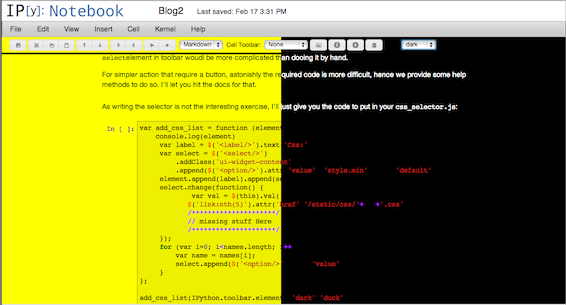

In [5]:
from IPython.display import Image
Image(filename='/Users/bussonniermatthias/Desktop/d-and-d.png')

> look closely, some buttons are unusual for a notebook...

So as you can see, not all the css does support variable right now, and if you know a little how the IPython notebook works, we use CodeMirror as an edittor and you might want to set the theme of all codemirror edittor at the same time. Hence the 

    /*********************/
    // missing stuff Here
    /*********************/
            
in the above snippet. One should both set the default CodeMirror theme on all cell, but also change the actual with:

    editor.setOption("theme", theme);
    
as well as load the corresponding css. This probably need a loop on `IPyhton.notebook.get_cells()`

Any way, I hope this show you that you can do a lot with the IPython notebook without diving deep into the source code. 

For the Lazy reader, the needed code and css files are availlabe [here], I'll probably move it in a more appropriate place later. 

You will still need to find the right place where to copy it, and add aline in your config.js (how hard!). Feel free to send me PR to improve this code/ share new css.

[here]: https://github.com/Carreau/ipython-static-profiles/tree/master/css_selector

### Next time

Next time we'll probably go back a little more on (I)Python side or explore some thought on what can be done on the Metadata in the notebook. 

I might also speek to you a little about nbconvert and the philosophy behind the notebook format.

If you have any comment, feel free to comment on the gihub repo of this blog post, and/or to send me PR to fix mistakes. 